# Monte Carlo Methods Exercises

**NOTICE:**
1. You are allowed to work in groups of up to three people but **have to document** your group's\
 members in the top cell of your notebook.
2. **Comment your code**, explain what you do (refer to the slides). It will help you understand the topics\
 and help me understand your thinking progress. Quality of comments will be graded.
3. **Discuss** and analyze your results, **write-down your learnings**. These exercises are no programming\
 exercises it is about learning and getting a touch for these methods. Such questions might be asked in the\
 final exams.
 4. Feel free to **experiment** with these methods. Change parameters think about improvements, write down\
 what you learned. This is not only about collecting points for the final grade, it is about understanding\
  the methods.

In [7]:
# If you run on google-colab you have to install this package whenever you start a kernel
!pip install gymnasium

### Exercise 1 - Blackjack (Monte Carlos ES)

**Summary:** In this exercise you will learn how to apply Monte Carlo ES to find the optimal strategy\
 playing the basic version of Blackjack. To do so you will implement the Monte Carlo (with exploring starts)\
  algorithm. This algorithm builds the basis for some variations we will talk about later in the lecture.\

  In Blackjack the Player plays versus the Dealer. The Dealer always follows the same algorithm. We can therefore\
  interpret the Dealer as part of the enivronment itself. See https://gymnasium.farama.org/environments/toy_text/blackjack/ \
  for more information about the exact game rules.


**Provided Code:** The cells below contains code to show you how to initialize the ```Blackjack-v1``` environment. See\
 https://gymnasium.farama.org/environments/toy_text/blackjack/ for more information about states, actions and\
 rewards.  Also provided is the ```test_policy()``` function which will help you compare the found policy by your implementation\
 with the mathematically optimal policy. The ```optimal_policy()``` is only used internally to compare policies\
 and is not required to solve the problem.



**Your Tasks in this exercise:**
1. Implement the Monte Carlo (ES) algorithm MC
    * Your implementation is only required to work for the ```Blackjack-v1``` environment
    * Your implementation should create a table (Q-Table) that contains the action-values for each state-action pair
    * You can use no discounted rewards (i.e.: $\gamma = 1.0$) for this example.
2. Test your Q-Table using the ```test_policy()``` function against the optimal policy.
    * The ```test_policy()``` will generate the greedy policy from your Q-Table (i.e.: pick the largest action under a state)
3. Answer and discuss the following questions:
    * Why is the exploring starts variation adequate for this environment? But not for the Frozen Lake environment we used before?
    * How can we speedup the implementation by improving on the pseudo code from the lecture?
    * Why can't we just use dynamic programming for this environment?
    * How many iterations does the algorithm require to find an approximately close policy to the optimal policy?

    

In [8]:
#@title **Provided Code:** ``optimal_policy()`` and ``test_policy()`` function.
import numpy as np

def optimal_policy(player, dealer, usable_ace):
    stick = 0
    hit = 1
    # Odds of the optimal policy are: Winning = 42.44%, Draw: 8.48%, Loss=49.10%

    if player < 12:
        return hit

    if usable_ace == 0:
        if dealer == 1 and player <= 16:
            return hit
        if (dealer == 2 or dealer == 3) and player == 12:
            return hit
        if (dealer >= 7 and dealer <= 9) and player <= 16:
            return hit
        if dealer == 10 and player <= 15:
            return hit
        return stick

    if usable_ace == 1:
        if player <= 17:
            return hit
        if (dealer == 1 or dealer == 9 or dealer == 10) and (player == 18):
            return hit
        return stick

def test_policy(env, Q, iterations=5000):
    '''
        Tests a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    wins_q = 0
    draws_q = 0
    losses_q = 0

    wins_o = 0
    draws_o = 0
    losses_o = 0

    for it in range(iterations):
        seed = np.random.randint(0, 100000)

        s,_ = env.reset(seed=seed)
        while True:
            a = int(np.argmax(Q[s[0], s[1], s[2], :]))
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    wins_q += 1
                if int(reward) == -1:
                    losses_q +=1
                if int(reward) == 0:
                    draws_q += 1
                break

        s,_ = env.reset(seed=seed)
        while True:
            player = s[0]
            dealer = s[1]
            usable_ace = s[2]

            a = optimal_policy(player, dealer, usable_ace)
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    wins_o += 1
                if int(reward) == -1:
                    losses_o +=1
                if int(reward) == 0:
                    draws_o += 1
                break

    print("Supplied Policy following Q -> Wins: %f, Draws: %f, Losses: %f" % (wins_q / iterations,draws_q/ iterations,losses_q/ iterations))
    print("Basic Policy (mathematically optimal without counting cards) -> Wins: %f, Draws: %f, Losses: %f" % (wins_o/ iterations,draws_o/ iterations,losses_o/ iterations))

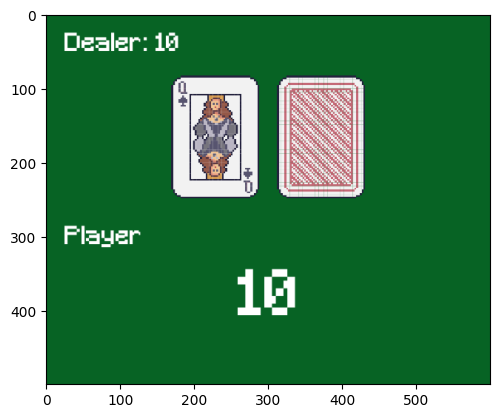

In [9]:
# Code to initialize the Environment.
#
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [24]:
Q = np.random.randn(33, 11, 2, 2)
Returns = {}
gamma = 1

for playerhand in range(1, 33):
  for dealerhand in range(1,11):
    for useAce in range(2):
      for action in [0,1]:
        Returns[(playerhand, dealerhand, useAce, action)] = []

currN = 0
n = 200000

while (currN < n):
  state, _ = env.reset()
  currentAction = int(env.action_space.sample())
  rewards = [0]
  states = [state]
  actions = [currentAction]

  while (True):
    state, reward, terminated, truncated, _ = env.step(currentAction)

    currentAction = int(np.argmax(Q[state[0], state[1], state[2], :]))

    rewards.append(reward)
    states.append(state)
    actions.append(currentAction)

    if (terminated):
      break;

  G = 0

  for t in reversed(range(len(rewards) - 1)):
      G = rewards[t+1] + gamma * G
      key = (states[t][0], states[t][1], states[t][2], actions[t])
      Returns[key].append(G)
      Q[states[t][0], states[t][1], states[t][2], actions[t]] = np.mean(Returns[key])

  currN +=1


currN
test_policy(env, Q)

Supplied Policy following Q -> Wins: 0.434200, Draws: 0.076800, Losses: 0.489000
Basic Policy (mathematically optimal without counting cards) -> Wins: 0.436600, Draws: 0.090000, Losses: 0.473400


### Exercise 2 - On-Policy first-visit MC Control


**Summary:** In this exercise you will adapt the Monte Carlo (ES) algorithm to use the ideas of the\
On-Policy first-visit MC Control instead. We will again use it to solve the ```FrozenLake-v1``` environment.


**Provided Code:** The cells below contains code to show you how to initialize the ```FrozenLake-v1``` environment.\
There will be two variations:
* ```lake_small``` - is a small without slipping
* ```lake_slippery``` - is a large environment with slipping

See https://gymnasium.farama.org/environments/toy_text/frozen_lake/ for more information about states, actions and\
 rewards.  

Also provided is the ```test_policy_lake()``` function which runs your policy multiple times and gives you the\
success rate of your policy. The ```run_and_visualize_policy_lake()``` function displays your policy using the\
environment.


**Your Tasks in this exercise:**
1. Implement the On-Policy first-visit MC Control algorithm
    * Adapt your implementation of the MC exploring start algorithm (they are quite similar)
    * **Hint:** To implement the $\epsilon$-soft policy simply generate a random value (drawn from a uniform distribution)\
    with a probability of $\epsilon$ select a random action and with a probability of $1-\epsilon$ select the greedy action
    of your current policy.  
    * You can assume that your implementation only needs to solve the ```FrozenLake-v1``` environment
    * To find the number of states you can use ```env.observation_space.n``` on the environment object
    * Your implementation should create a table (Q-Table) that contains the action-values for each state-action pair
    

2. Run your implementation to solve the ```lake_small``` environment
    * Execute the ```test_policy_lake()``` to find your success rate
3. Try to solve the ```lake_slippery``` environment  (note that this might not work)
    * Execute the ```test_policy_lake()``` to find your success rate

4. Analyze, discuss and answer the following questions:
    * Why is the exploring starts variation not adequate for this environment? But not for the Black Jack environment we used before?
    * Why is it easy to solve the ```lake_small``` but seems impossible to solve the ```lake_slippery``` environment?
    * Explain the differences to the Monte Carlo exploring starts algorithm




In [ ]:
#@title **Provided Code:** ``run_and_visualize_policy_lake()`` and ``test_policy_lake()`` function.

from IPython import display
import time
def run_and_visualize_policy_lake(env, Q, delay=0.175):
    '''
        Visualizes a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    s, _ = env.reset()
    plt.imshow(env.render())

    while True:
        a = np.argmax(Q[s])
        s,_,terminated,truncated,_ = env.step(a)
        plt.imshow(env.render())
        plt.show()
        display.clear_output(wait=True)
        time.sleep(delay)

        if terminated or truncated:
            break

def test_policy_lake(env, Q, iterations=500):
    '''
        Tests a policy.
        env - FrozenLake-v1 environment.
        pi - A policy (i.e. a numpy.ndarray such that pi[state] = action).
    '''
    success_cnt = 0
    for it in range(iterations):
        s,_ = env.reset()
        while True:
            a = np.argmax(Q[s])
            s,reward,terminated,truncated,_ = env.step(a)

            if terminated == True or truncated == True:
                if int(reward) == 1:
                    success_cnt += 1
                break

    return 100 * (success_cnt / iterations)

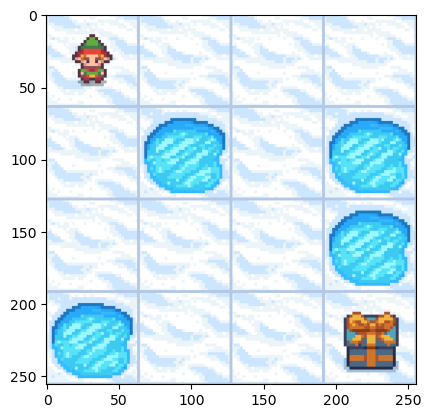

In [ ]:
# This cell initializes the environment and the system dynamics object.
#
import matplotlib.pyplot as plt
import gymnasium as gym

lake_small = gym.make('FrozenLake-v1',  map_name="4x4", is_slippery=False, render_mode='rgb_array')

lake_slippery = gym.make('FrozenLake-v1', desc=['SFHFFFFF', 'FFHFFFFF', 'FFHFFHFF', 'FFHFFHFF','FFHFFHFF','FFHFFHFF','FFFFFHFF','FFFFFHFG'],
                        is_slippery=True, render_mode='rgb_array')
lake_slippery._max_episode_steps = 2000

lake_slippery.reset()
lake_small.reset()
plt.imshow(lake_small.render())

### Exercise 3 - Importance Sampling

**Summary:** In this exercise we will have a look at a simple and straight-forwards implementation of ordinary and weighted importance sampling.


**Provided Code:** I have provided you with the implementation of ordinary and weighted importance sampling using epsilon-greedy behavior policies\
which are based on the current estimate of Q.



**Your Tasks in this exercise:**
1. Read through and discuss the code thoroughly and the comments try to match the theory and practise.
2. Answer the following questions:
    * How is the epsilon-greedy behavior policy implemented?
    * How are the trajectory probabilities calculated?
    * Why do we use 1 instead of computing the trajectory's probability under the target policy?
    * Explain why we say that MC-off-policy learns from the tail of an episode and how this algorithms are inconsistent\
    with the mathematics.
    * Compare the convergence behavior of both implementations, which one learns faster and why?
    * Explain how we could speedup the computation of these algorithms.
    


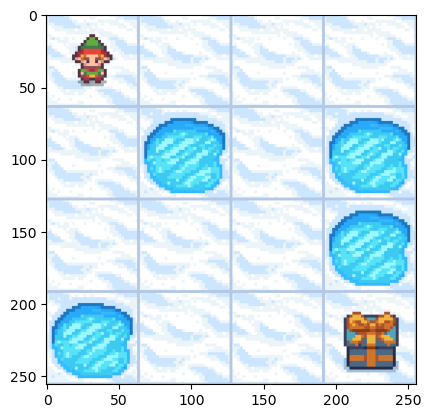

In [ ]:
# This cell initializes the environment and the system dynamics object.
#
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np

lake_small = gym.make('FrozenLake-v1',  map_name="4x4", is_slippery=False, render_mode='rgb_array')
lake_small.reset()
plt.imshow(lake_small.render())

In [ ]:
import numpy as np

def weighted_importance_sampling(env, n_episodes, gamma=0.9, eps=0.1):

    Q = np.random.randn(env.observation_space.n, env.action_space.n)
    pi = np.argmax(Q, axis=1) # this represents the the greedy target policy

    Q_dict = dict() # This stores the sampled returns G_t for each state,action pair
    W_dict = dict() # This stores the importance sampling weights for each state,action pair

    cur_episode = 0
    while cur_episode < n_episodes:
        # Entertain the user while waiting for the algorithm.
        #
        if((cur_episode % 1000) == 0):
            print(cur_episode)

        # Generate an episode using the behavior policy.
        #
        s_t, _ = env.reset()
        episode_sequence = []

        while True:


            # The behavior policy is usually an epsilon-soft variant of the current greedy policy.
            # We roll a dice and check the value, in most cases we use the greedy policy but
            # in some cases we explore and use some random action.
            #
            eps_sample = np.random.rand()

            prob_a = 0
            if eps_sample < eps: # pick any random action (including the greedy)
                a_t = env.action_space.sample()

                # probability of any action taking epsilon into account
                # (see epsilon-soft policies for derivation)
                #
                prob_a = eps / env.action_space.n
            else: # pick the greedy action following the current greedy policy
                a_t = pi[s_t]

                # probability of the greedy action taking epsilon into account
                # (see epsilon-soft policies for derivation)
                #
                prob_a = 1 - eps + eps/ env.action_space.n


            # Take action
            #
            s_tplus1, r_tplus1, terminated, truncated, _ = env.step(a_t)

            # Notice, we now also store the probability of the action as we need it later
            # to compute the important sampling ratios.
            #
            episode_sequence.append( (s_t, a_t, r_tplus1, prob_a) )

            if terminated or truncated:
                break
            s_t = s_tplus1

        # We now have a full sequence and use the same idea as in On-Policy MC going from
        # the end to the front of the episode. Notice this implementation is an every-visit
        # variation.
        #
        G = 0 # Return

        behavior_prob = 1 # probability of sequence under the behavior policy

        for t in range(len(episode_sequence)-1, -1, -1):
            # Pick tuple
            #
            tuple = episode_sequence[t]
            state_t = tuple[0]
            action_t = tuple[1]
            reward_tplus1 = tuple[2]
            prob_a = tuple[3]

            G = gamma * G + reward_tplus1

            # Probability of observing this sequence starting at S_t under
            # the behavior policy.
            #
            behavior_prob = behavior_prob * prob_a

            # For sake of readability this is a not very efficient implementation
            # we simply store the importance sampling ratios and "corrected" returns.
            # We could also implement this using incremental updates.
            #
            key = (state_t, action_t)
            if key not in Q_dict.keys():
                Q_dict[key] = []
                W_dict[key] = [] # Importance Sampling Ratio weights

            Q_dict[key].append((1.0/behavior_prob) * G) # Store corrected return for state,action pair
            W_dict[key].append((1.0/behavior_prob)) # Store the importance sampling ratio for the state,action pair

            # Estimate the action-value using weighted importance sampling.
            #
            Q[state_t,action_t] = np.sum(Q_dict[key]) / np.sum(W_dict[key])

            # Update the target policy being greedy.
            #
            pi[state_t] = np.argmax(Q[state_t,:])

            # Note: Following the math, this should be performed before doing the updates above because
            # we ignored that the target_prob of the last step is 0. This means the target policy is inconsistent
            # with the behavior policy ... The importance sampling ratio is therefore 0 and we should end the learning.
            #
            # Although this is not mentioned in the book, this is unortunately an example that shows how the math works
            # in infinity but fails to converge fast enough in real-world. Doing this we ensure that there is at least 1
            # update step at the end of the episode, even though our estimates are not mathematically correct. This is why
            # it is said that "MC-off-policy only learns from the tails of episodes".
            #
            if pi[state_t] != action_t:
                break

        cur_episode = cur_episode + 1

    return pi,Q


In [ ]:
pi, Q = weighted_importance_sampling(lake_small, 20000)
test_policy_lake(lake_small, Q)

In [ ]:
run_and_visualize_policy_lake(lake_small, Q)

In [ ]:
def ordinary_importance_sampling(env, n_episodes, gamma=0.9, eps=0.1):

    Q = np.random.randn(env.observation_space.n, env.action_space.n)
    pi = np.argmax(Q, axis=1) # this represents the the greedy target policy

    Q_dict = dict() # This stores the sampled returns G_t for each state,action pair
    N_dict = dict() # This the number of times we collected a return for a state,action pair

    cur_episode = 0
    while cur_episode < n_episodes:
        # Entertain the user while waiting for the algorithm.
        #
        if((cur_episode % 1000) == 0):
            print(cur_episode)

        # Generate an episode using the behavior policy.
        #
        s_t, _ = env.reset()
        episode_sequence = []

        while True:


            # The behavior policy is usually an epsilon-soft variant of the current greedy policy.
            # We roll a dice and check the value, in most cases we use the greedy policy but
            # in some cases we explore and use some random action.
            #
            eps_sample = np.random.rand()

            prob_a = 0
            if eps_sample < eps: # pick any random action (including the greedy)
                a_t = env.action_space.sample()

                # probability of any action taking epsilon into account
                # (see epsilon-soft policies for derivation)
                #
                prob_a = eps / env.action_space.n
            else: # pick the greedy action following the current greedy policy
                a_t = pi[s_t]

                # probability of the greedy action taking epsilon into account
                # (see epsilon-soft policies for derivation)
                #
                prob_a = 1 - eps + eps / env.action_space.n


            # Take action
            #
            s_tplus1, r_tplus1, terminated, truncated, _ = env.step(a_t)

            # Notice, we now also store the probability of the action as we need it later
            # to compute the important sampling ratios.
            #
            episode_sequence.append( (s_t, a_t, r_tplus1, prob_a) )

            if terminated or truncated:
                break
            s_t = s_tplus1

        # We now have a full sequence and use the same idea as in On-Policy MC going from
        # the end to the front of the episode. Notice this implementation is an every-visit
        # variation.
        #
        G = 0 # Return

        behavior_prob = 1 # probability of sequence under the behavior policy

        for t in range(len(episode_sequence)-1, -1, -1):
            # Pick tuple
            #
            tuple = episode_sequence[t]
            state_t = tuple[0]
            action_t = tuple[1]
            reward_tplus1 = tuple[2]
            prob_a = tuple[3]

            G = gamma * G + reward_tplus1

            # Probability of observing this sequence starting at S_t under
            # the behavior policy.
            #
            behavior_prob = behavior_prob * prob_a

            # For sake of readability this is a not very efficient implementation
            # we simply store the importance sampling ratios and "corrected" returns.
            # We could also implement this using incremental updates.
            #
            key = (state_t, action_t)
            if key not in Q_dict.keys():
                Q_dict[key] = []
                N_dict[key] = [] # Importance Sampling Ratio weights

            Q_dict[key].append((1.0/behavior_prob) * G) # Store corrected return for state,action pair
            N_dict[key].append(1) # Store the importance sampling ratio for the state,action pair

            # Estimate the action-value using weighted importance sampling.
            #
            Q[state_t,action_t] = np.sum(Q_dict[key]) / np.sum(N_dict[key])

            # Update the target policy being greedy.
            #
            pi[state_t] = np.argmax(Q[state_t,:])

            # Note: Following the math, this should be performed before doing the updates above because
            # we ignored that the target_prob of the last step is 0. This means the target policy is inconsistent
            # with the behavior policy ... The importance sampling ratio is therefore 0 and we should end the learning.
            #
            # Although this is not mentioned in the book, this is unortunately an example that shows how the math works
            # in infinity but fails to converge fast enough in real-world. Doing this we ensure that there is at least 1
            # update step at the end of the episode, even though our estimates are not mathematically correct. This is why
            # it is said that "MC-off-policy only learns from the tails of episodes".
            #
            if pi[state_t] != action_t:
                break

        cur_episode = cur_episode + 1

    return pi,Q


In [ ]:
pi, Q = ordinary_importance_sampling(lake_small, 20000)
test_policy_lake(lake_small, Q)

In [ ]:
run_and_visualize_policy_lake(lake_small, Q)

Answers